In [3]:
%pwd

'c:\\Users\\odz-2\\Desktop\\itü\\bitirme\\2nd part\\exercise-chatbot-project\\exercise-chatbot-project'

In [2]:
import os
os.chdir("../")

In [4]:
%load_ext autoreload
%autoreload 2

import os
from dotenv import load_dotenv

# Load API keys
load_dotenv()

True

In [5]:
GOOGLE_API_KEY= os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GRADER_API_KEY = os.getenv("GRADER_API_KEY")
GENERATOR_GOOGLE_API_KEY = os.getenv("GENERATOR_GOOGLE_API_KEY")

os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["GRADER_API_KEY"] = GRADER_API_KEY
os.environ["GENERATOR_GOOGLE_API_KEY"] = GENERATOR_GOOGLE_API_KEY

In [13]:
import os
from langchain_community.document_loaders import DirectoryLoader, TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone, ServerlessSpec

In [7]:
pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))
index_name = "fitness-chatbot"

if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=384, # Dimension for 'all-MiniLM-L6-v2'
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )

index = pc.Index(index_name)


In [8]:
from langchain_community.document_loaders import PyPDFLoader

loaders = {
    ".txt": TextLoader,
    ".pdf": PyPDFLoader
}


def create_loader(file_path):
    ext = os.path.splitext(file_path)[1]
    if ext in loaders:
        return loaders[ext](file_path)
    return None

path = "data/knowledge_base/"
docs = []

for file in os.listdir(path):
    loader = create_loader(os.path.join(path, file))
    if loader:
        docs.extend(loader.load())

print(f"Loaded {len(docs)} documents (7 TXTs and 2 PDFs).")


Loaded 166 documents (7 TXTs and 2 PDFs).


In [ ]:
docs

In [10]:
from typing import List
from langchain_core.documents import Document

def filter_to_minimal_docs(docs: List[Document]) -> List[Document]:
    
    minimal_docs: List[Document] = []
    for doc in docs:
        src = doc.metadata.get("source")
        minimal_docs.append(
            Document(
                page_content = doc.page_content,
                metadata={"source": src}
            )
        )
    return minimal_docs

In [11]:
minimal_docs = filter_to_minimal_docs(docs)

In [ ]:
minimal_docs

In [13]:
def text_split(minimal_docs):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=700,
        chunk_overlap=100
        )
    text_chunks = text_splitter.split_documents(minimal_docs)
    return text_chunks\
    


In [14]:
texts_chunks = text_split(minimal_docs)
print(f"Number of chunks: {len(texts_chunks)}")

Number of chunks: 532


In [15]:
def download_embeddings():
    model_name = "all-MiniLM-L6-v2"
    embeddings = HuggingFaceEmbeddings(
        model_name=model_name,
        
    )
    return embeddings

embedding = download_embeddings()

In [16]:
#converting the text chunks into embeddings and storing them in Pinecone vector store

docsearch = PineconeVectorStore.from_documents(
    documents=texts_chunks,
    embedding=embedding,
    index_name=index_name
)

In [17]:
docsearch = PineconeVectorStore.from_existing_index(
    embedding=embedding,
    index_name=index_name
)

In [ ]:
def test_search(query):
    # k=3 means "find the top 3 most relevant paragraphs"
    results = docsearch.similarity_search(query, k=3)
    for i, res in enumerate(results):
        print(f"\n--- Result {i+1} (Source: {res.metadata.get('source')}) ---")
        print(res.page_content[:300] + "...")

test_search("What are the guidelines for exercising with hypertension?")

In [6]:
from langgraph.graph import StateGraph, START, END
from graphs.state import GraphState
from dotenv import load_dotenv
from graphs.nodes.query_analysis import query_analyzer_node
from graphs.nodes.retriever import retriever_node
from graphs.nodes.generator import generator_node
from graphs.nodes.web_search import web_search_node
from graphs.nodes.safety_grader import safety_grader_node
from graphs.nodes.greeting import greeting_node


c:\Users\odz-2\anaconda3\envs\excbot\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\odz-2\anaconda3\envs\excbot\Lib\site-packages\langchain_tavily\tavily_research.py:97: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]
c:\Users\odz-2\anaconda3\envs\excbot\Lib\site-packages\langchain_tavily\tavily_research.py:97: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]


In [7]:
from langgraph.checkpoint.memory import InMemorySaver
load_dotenv()

def route_greeting(state: GraphState):
    """
    If onboarding is not complete (first message), we wait for user input.
    Otherwise, we proceed to analysis.
    """
    if state.get("onboarding_complete") is False:
        print("---ONBOARDING INCOMPLETE: WAITING FOR USER---")
        return "wait_for_user"
    print("---ONBOARDING COMPLETE: PROCEEDING TO ANALYSIS---")
    return "analyze"

def route_question(state: GraphState):
    """
    Determines if we go to the local VectorDB or the Web.
    """
    if state.get("datasource") == "web_search":
        print("---ROUTING TO WEB SEARCH---")
        return "web_search"
    elif state.get("datasource") == "none":
        print("---ROUTING TO GENERAL CHAT---")
        return "just_chat"
    else:
        print("---ROUTING TO LOCAL RETRIEVER---")
        return "retrieve_local"
    
def decide_to_finish(state):
    if state["is_safe"] == "yes":
        return "safe"
    return "unsafe"

def route_after_generation(state: GraphState):
    """
    Decide whether to grade the output or just finish.
    """
    # If the intent was a greeting or general chat, just stop.
    # We access this from the user_profile we stored in query_analysis.
    user_profile = state.get("user_profile", {})
    if user_profile.get("intent") in ["greeting", "general_chat"]:
        return "finish"
    
    # Otherwise, it's a workout—run it by the doctor (grader)
    return "grade"

workflow = StateGraph(GraphState)
memory = InMemorySaver()

# 2. Add the Nodes you've created
workflow.add_node("greeting", greeting_node)
workflow.add_node("analyze_query", query_analyzer_node)
workflow.add_node("retrieve_local", retriever_node)
workflow.add_node("web_search", web_search_node)
workflow.add_node("generate_workout", generator_node)
workflow.add_node("safety_grader", safety_grader_node)

workflow.add_edge(START, "greeting")

# 2. Conditional Edge from Greeting
workflow.add_conditional_edges(
    "greeting",
    route_greeting,
    {
        "wait_for_user": END,   # Stops here so user can see the greeting and reply
        "analyze": "analyze_query" # Proceeds if user has already replied
    }
)

# Add the Decision Path
workflow.add_conditional_edges(
    "analyze_query",
    route_question,
    {
        "retrieve_local": "retrieve_local",
        "web_search": "web_search",
        "just_chat": "generate_workout"
    }
)

# Both paths lead to the Generator
workflow.add_edge("retrieve_local", "generate_workout")
workflow.add_edge("web_search", "generate_workout")
workflow.add_conditional_edges(
    "generate_workout",
    route_after_generation,
    {
        "finish": END,
        #"grade": END
        "grade": "safety_grader"
    }
)

workflow.add_conditional_edges(
    "safety_grader",
    decide_to_finish,
    {
        "safe": END,
        "unsafe": "generate_workout"  # This creates the LOOP
    }
)

# 4. Compile the Graph
app = workflow.compile(checkpointer=memory)

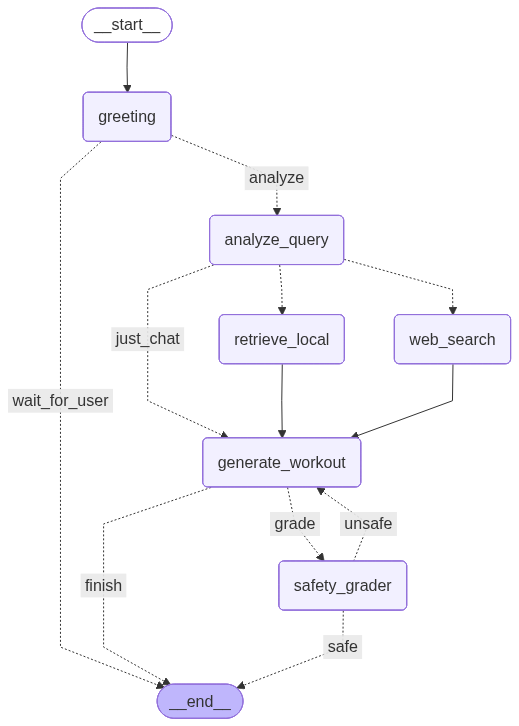

In [8]:
#visualize the graph structure in a Mermaid chart

from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies, so it might fail
    print("Graph compiled successfully (but couldn't render image).")

In [10]:
# Test Input
inputs = {"question": "I have lower back pain and want to train my glutes."}

# Config is required for thread-based memory
config = {"configurable": {"thread_id": "user_session_1"}}

# Run the graph and stream the updates
for output in app.stream(inputs, config):
    for key, value in output.items():
        print(f"--- Finished Node: {key} ---")
        # Optional: print(value) to see the state update from that node

---NODE: ANALYZING USER QUERY---
---ROUTING TO LOCAL RETRIEVER---
--- Finished Node: analyze_query ---
---NODE: RETRIEVING & FILTERING---
--- Finished Node: retrieve_local ---
---NODE: GENERATING WORKOUT PLAN---
--- Finished Node: generate_workout ---
---NODE: GRADING SAFETY---
--- Finished Node: safety_grader ---


In [11]:
#since we provided the memory now, by using the same thread_id, we expect it to remember the previous query and answer
#so we pull a follow-up input

follow_up_inputs = {"question": "Can you replace one of those exercises with something I can do at home?"}

# Using the SAME thread_id pulls the previous state back out of memory
config = {"configurable": {"thread_id": "user_session_1"}}

for output in app.stream(follow_up_inputs, config):
    print(f"--- Node: {list(output.keys())[0]} ---")

---NODE: ANALYZING USER QUERY---
---ROUTING TO WEB SEARCH---
--- Node: analyze_query ---
---NODE: WEB SEARCH---
--- Node: web_search ---
---NODE: GENERATING WORKOUT PLAN---
--- Node: generate_workout ---
---NODE: GRADING SAFETY---
--- Node: safety_grader ---


In [18]:
from langchain_core.messages import HumanMessage

# Define your configuration (Thread ID is the most important part)
config = {"configurable": {"thread_id": "comprehensive_test_002"}}

# --- TURN 1: Initial Request ---
print("--- TURN 1: INITIAL REQUEST ---")
input_1 = {"messages": [HumanMessage(content="I have lower back pain and want to train glutes.")]}
for output in app.stream(input_1, config):
    print(f"Node: {list(output.keys())[0]}")

# --- TURN 2: Follow-up (The Memory Test) ---
print("\n--- TURN 2: FOLLOW-UP (CONTEXT TEST) ---")
# Notice we DON'T mention back pain here
input_2 = {"messages": [HumanMessage(content="Can you make that a bodyweight-only version?")]}
for output in app.stream(input_2, config):
    print(f"Node: {list(output.keys())[0]}")

# --- TURN 3: Verification ---
print("\n--- FINAL VERIFICATION ---")
final_state = app.get_state(config)
print(f"Total Messages in History: {len(final_state.values['messages'])}")
print(f"Latest Generation Peek: {final_state.values['generation'][:100]}...")

--- TURN 1: INITIAL REQUEST ---
---NODE: ANALYZING USER QUERY---
---ROUTING TO LOCAL RETRIEVER---
Node: analyze_query
---NODE: RETRIEVING & FILTERING---
Node: retrieve_local
---NODE: GENERATING WORKOUT PLAN---
Node: generate_workout
---NODE: GRADING SAFETY---
Node: safety_grader

--- TURN 2: FOLLOW-UP (CONTEXT TEST) ---
---NODE: ANALYZING USER QUERY---
---ROUTING TO LOCAL RETRIEVER---
Node: analyze_query
---NODE: RETRIEVING & FILTERING---
Node: retrieve_local
---NODE: GENERATING WORKOUT PLAN---
Node: generate_workout
---NODE: GRADING SAFETY---
Node: safety_grader

--- FINAL VERIFICATION ---
Total Messages in History: 4
Latest Generation Peek: Absolutely! We can definitely make that a bodyweight-only routine. Focusing on controlled movements ...


In [8]:
from langchain_core.messages import HumanMessage

# This is your conversation "Key"
config = {"configurable": {"thread_id": "final_user_test_session2"}}

print("Elite Medical Fitness Coach is Online. (Type 'exit' to stop)")
print("-" * 50)

while True:
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit", "stop"]:
        break

    # Send the message to the graph
    inputs = {"messages": [HumanMessage(content=user_input)]}
    
    # We use stream so we can see when it's thinking
    final_response = ""
    for output in app.stream(inputs, config):
        for key, value in output.items():
            if key == "retrieve_local":
                print(f"DEBUG: Found {len(value.get('safe_exercises', []))} safe exercises in JSON.")
            # We look for the generator node or the final state update
            if "generation" in value:
                final_response = value["generation"]
    
    print(f"\nCoach: {final_response}")
    print("-" * 50)

Elite Medical Fitness Coach is Online. (Type 'exit' to stop)
--------------------------------------------------
---NODE: ANALYZING USER QUERY---
DEBUG: Query Analyzer produced dict: {'name': 'User', 'intent': 'workout_request', 'conditions': [], 'goals': ['quadriceps', 'hamstrings', 'glutes', 'calves'], 'workout_type': 'strength', 'level': 'beginner', 'emergency': False}
---ROUTING TO LOCAL RETRIEVER---
---NODE: RETRIEVING & FILTERING---
DEBUG: AI extracted goals: ['quadriceps', 'hamstrings', 'glutes', 'calves']
DEBUG: Found 7 safe exercises in JSON.
---NODE: GENERATING WORKOUT PLAN---

Coach: Hello there! I'm happy to help you build a lower body strength workout plan. It's great that you're focusing on strengthening your quadriceps, hamstrings, and glutes.

First, let's address a common concern: the fear that "exercise damages the knee" is unsupported by robust safety data. In fact, our research indicates that exercise does **not** increase the risk of harm compared to doing nothing. 

In [8]:
from langchain_core.messages import HumanMessage

# Use a fresh thread ID to test the greeting logic
config = {"configurable": {"thread_id": "test_fresh_start_02"}}

# --- TURN 1: Trigger the Greeting ---
print("System: Starting onboarding...")
# We start with NO messages to trigger the greeting_node
for output in app.stream({"messages": []}, config):
    for key, value in output.items():
        if key == "greeting" and "messages" in value:
            print(f"\nCoach: {value['messages'][-1].content}")

# --- TURN 2+: Enter the User Loop ---
while True:
    print("-" * 50)
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit"]: break

    # Send the user's profile info
    inputs = {"messages": [HumanMessage(content=user_input)]}
    
    final_response = ""
    for output in app.stream(inputs, config):
        for node_name, state_update in output.items():
            print(f"--- Processing Node: {node_name} ---")
            
            if node_name == "generate_workout":
                final_response = state_update.get("generation", "")

    if final_response:
        print(f"\nCoach: {final_response}")

System: Starting onboarding...
---ONBOARDING INCOMPLETE: WAITING FOR USER---

Coach: Welcome to Elite Medical Fitness! 🏋️‍♂️

To build a workout that is safe for your body, I need to know three things:
1. Your **Experience Level** (Beginner, Intermediate, or Advanced)
2. Your **Goal** for today (Lower Body, Upper Body, Cardio, or a specific muscle)
3. Any **Health Conditions** or pains (e.g., 'Lower back pain', 'Hypertension', or 'None')

How can I help you get started today?
--------------------------------------------------
---ONBOARDING COMPLETE: PROCEEDING TO ANALYSIS---
--- Processing Node: greeting ---
---NODE: ANALYZING USER QUERY---
DEBUG: Query Analyzer produced dict: {'name': 'User', 'intent': 'workout_request', 'conditions': ['hypertension'], 'goals': ['upper body'], 'workout_type': 'balanced', 'level': 'intermediate', 'emergency': False}
---ROUTING TO LOCAL RETRIEVER---
--- Processing Node: analyze_query ---
---NODE: RETRIEVING & FILTERING---
DEBUG: Programmed Menu Categori